In [113]:
import warnings
import numpy as np 
import pandas as pd

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

warnings.filterwarnings('ignore')

Дропаем колонки `Name`, `Ticket`, `Cabin` т.к. они не несут полезное признаковое описание пассажира.

In [64]:
data = pd.read_csv('./data/raw/train.csv')
data.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S


## EDA

**Посмотрим на фичи и их влияние на таргет**

Посмотрим на фичу `Sex`

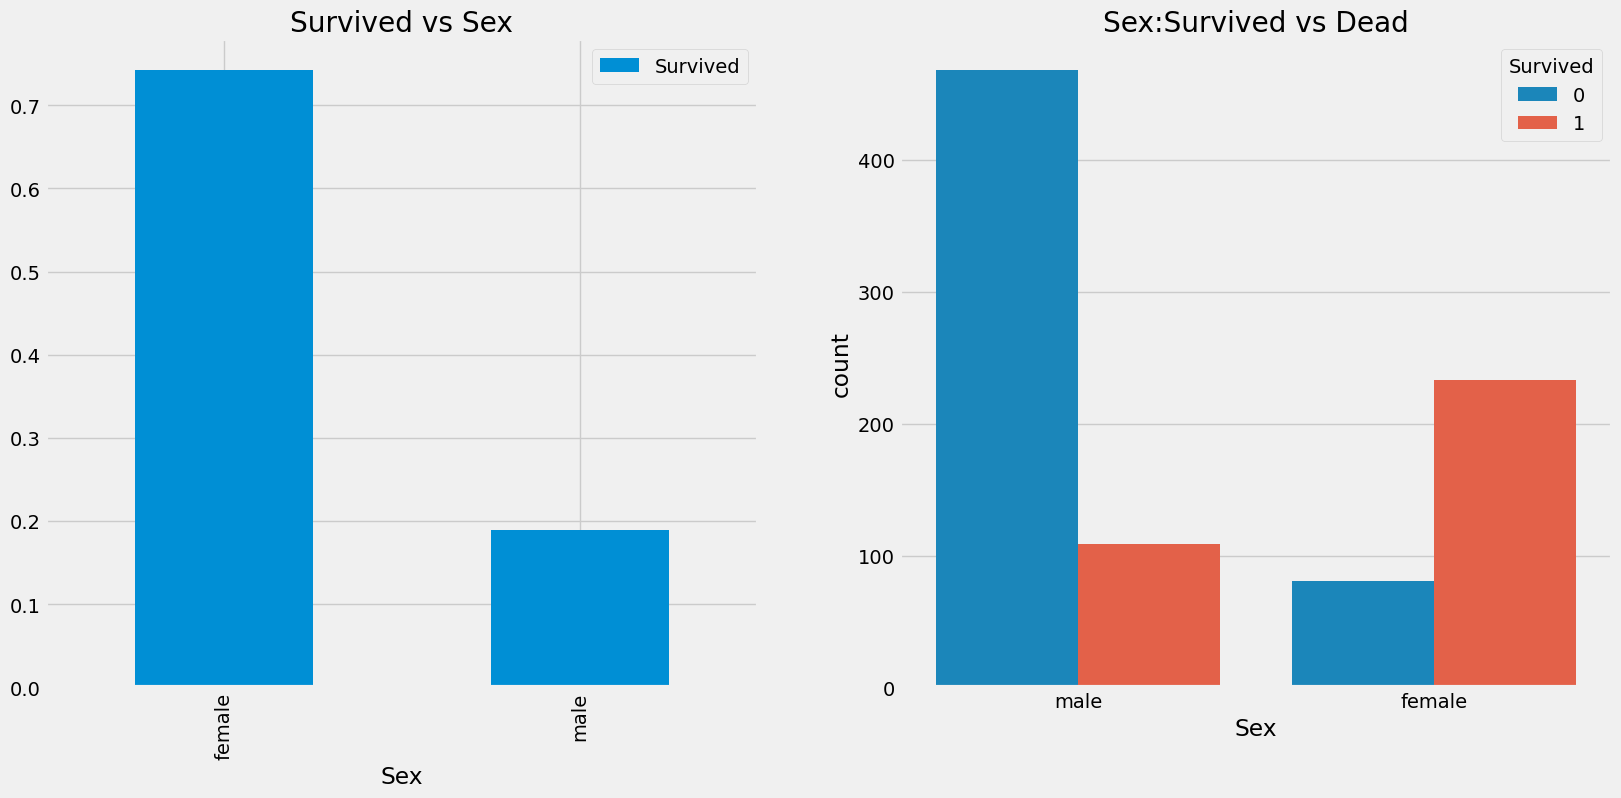

In [16]:
f,ax=plt.subplots(1,2,figsize=(18,8))
data[['Sex','Survived']].groupby(['Sex']).mean().plot.bar(ax=ax[0])
ax[0].set_title('Survived vs Sex')
sns.countplot(x='Sex',hue='Survived',data=data,ax=ax[1])
ax[1].set_title('Sex:Survived vs Dead')
plt.show()

Посмотрим на фичу `Pclass`

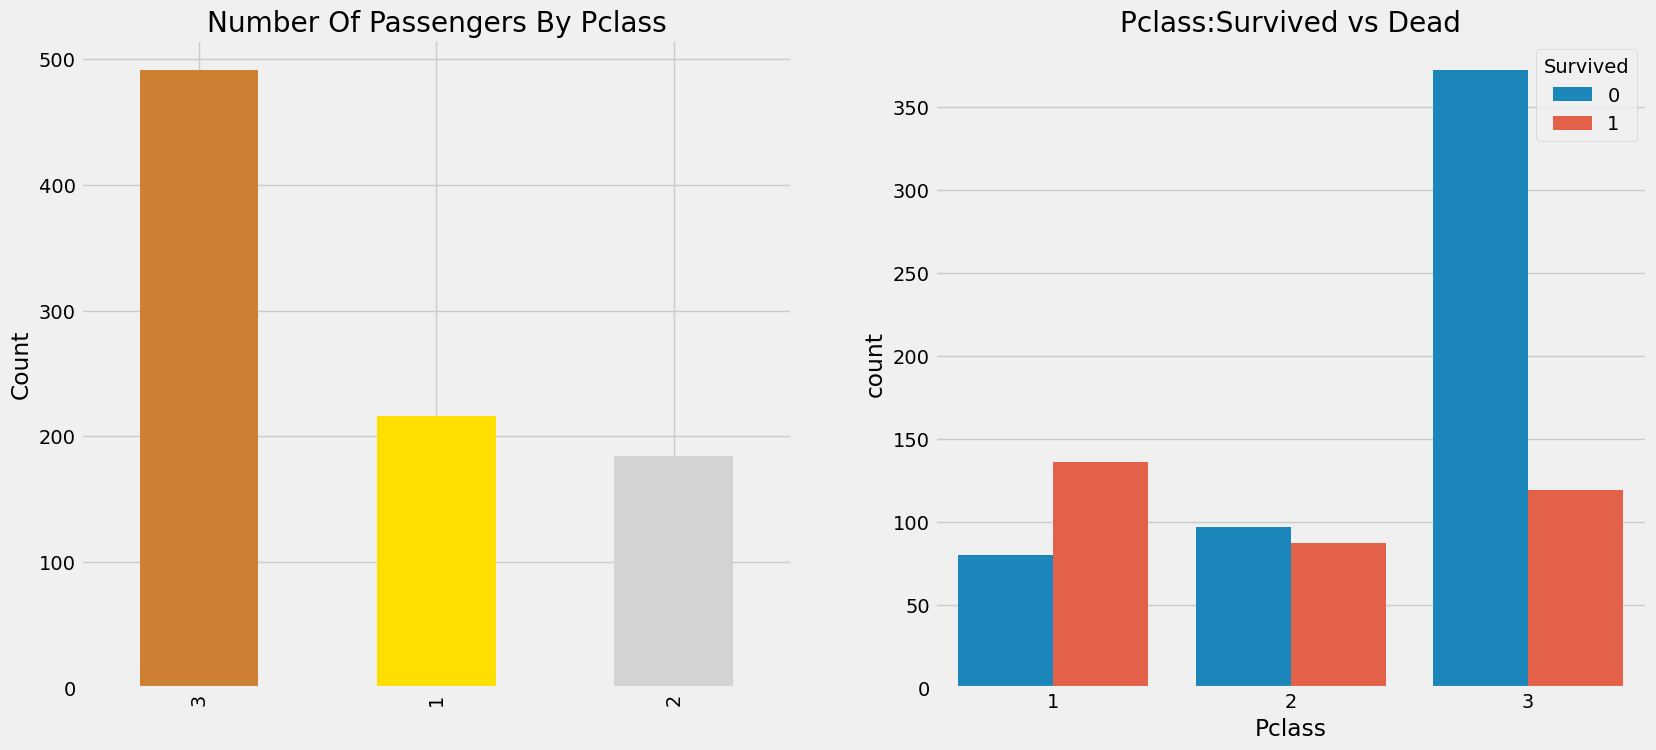

In [17]:
f,ax=plt.subplots(1,2,figsize=(18,8))
data['Pclass'].value_counts().plot.bar(color=['#CD7F32','#FFDF00','#D3D3D3'],ax=ax[0])
ax[0].set_title('Number Of Passengers By Pclass')
ax[0].set_ylabel('Count')
sns.countplot(x='Pclass',hue='Survived',data=data,ax=ax[1])
ax[1].set_title('Pclass:Survived vs Dead')
plt.show()

Посмотрим на фичу `Age`

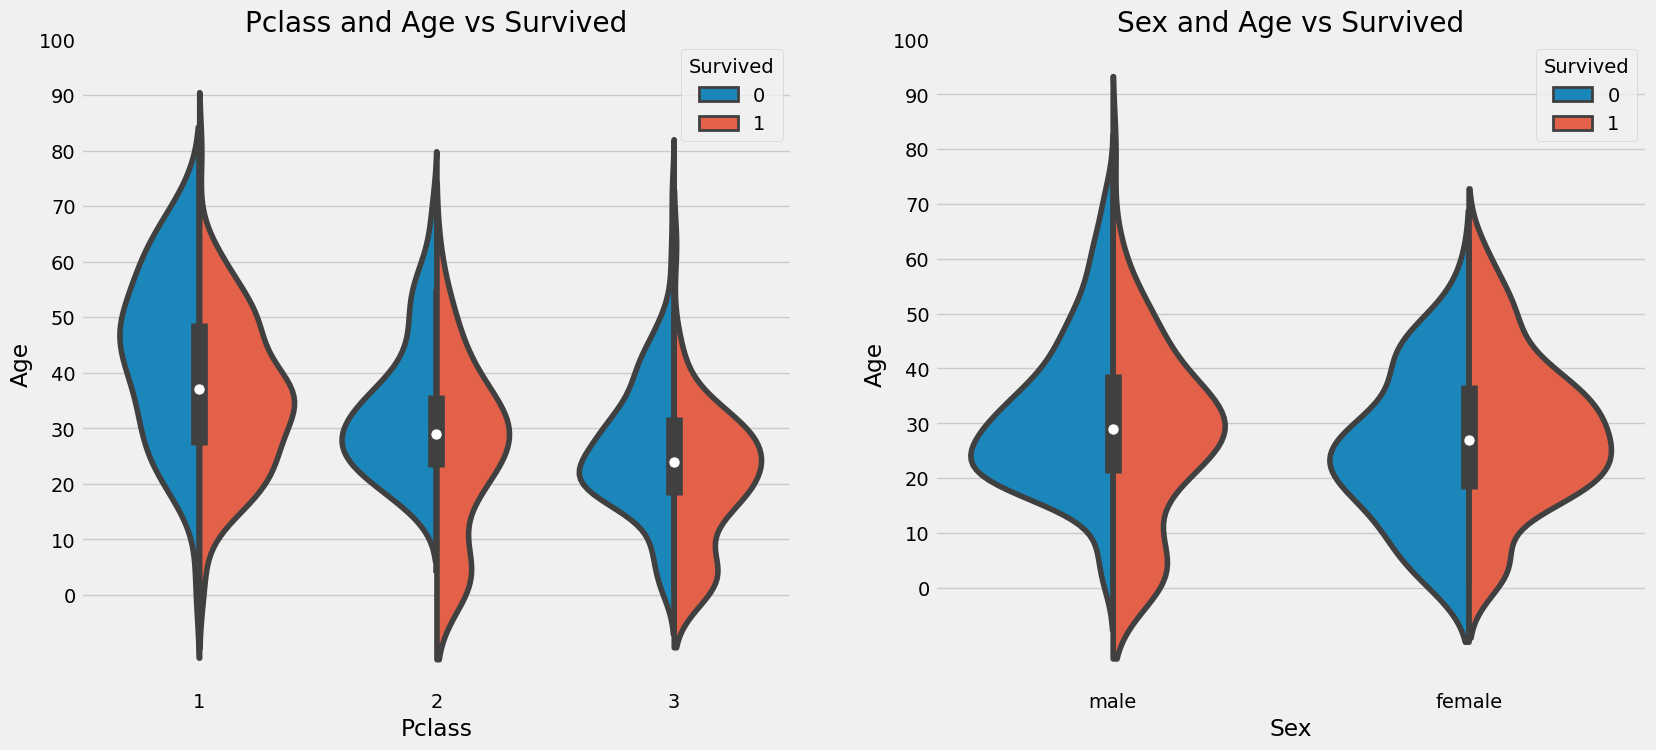

In [19]:
f,ax=plt.subplots(1,2,figsize=(18,8))
sns.violinplot(x="Pclass",y="Age", hue="Survived", data=data,split=True,ax=ax[0])
ax[0].set_title('Pclass and Age vs Survived')
ax[0].set_yticks(range(0,110,10))
sns.violinplot(x="Sex",y="Age", hue="Survived", data=data,split=True,ax=ax[1])
ax[1].set_title('Sex and Age vs Survived')
ax[1].set_yticks(range(0,110,10))
plt.show()

Посмотрим на фичу `Embarked`

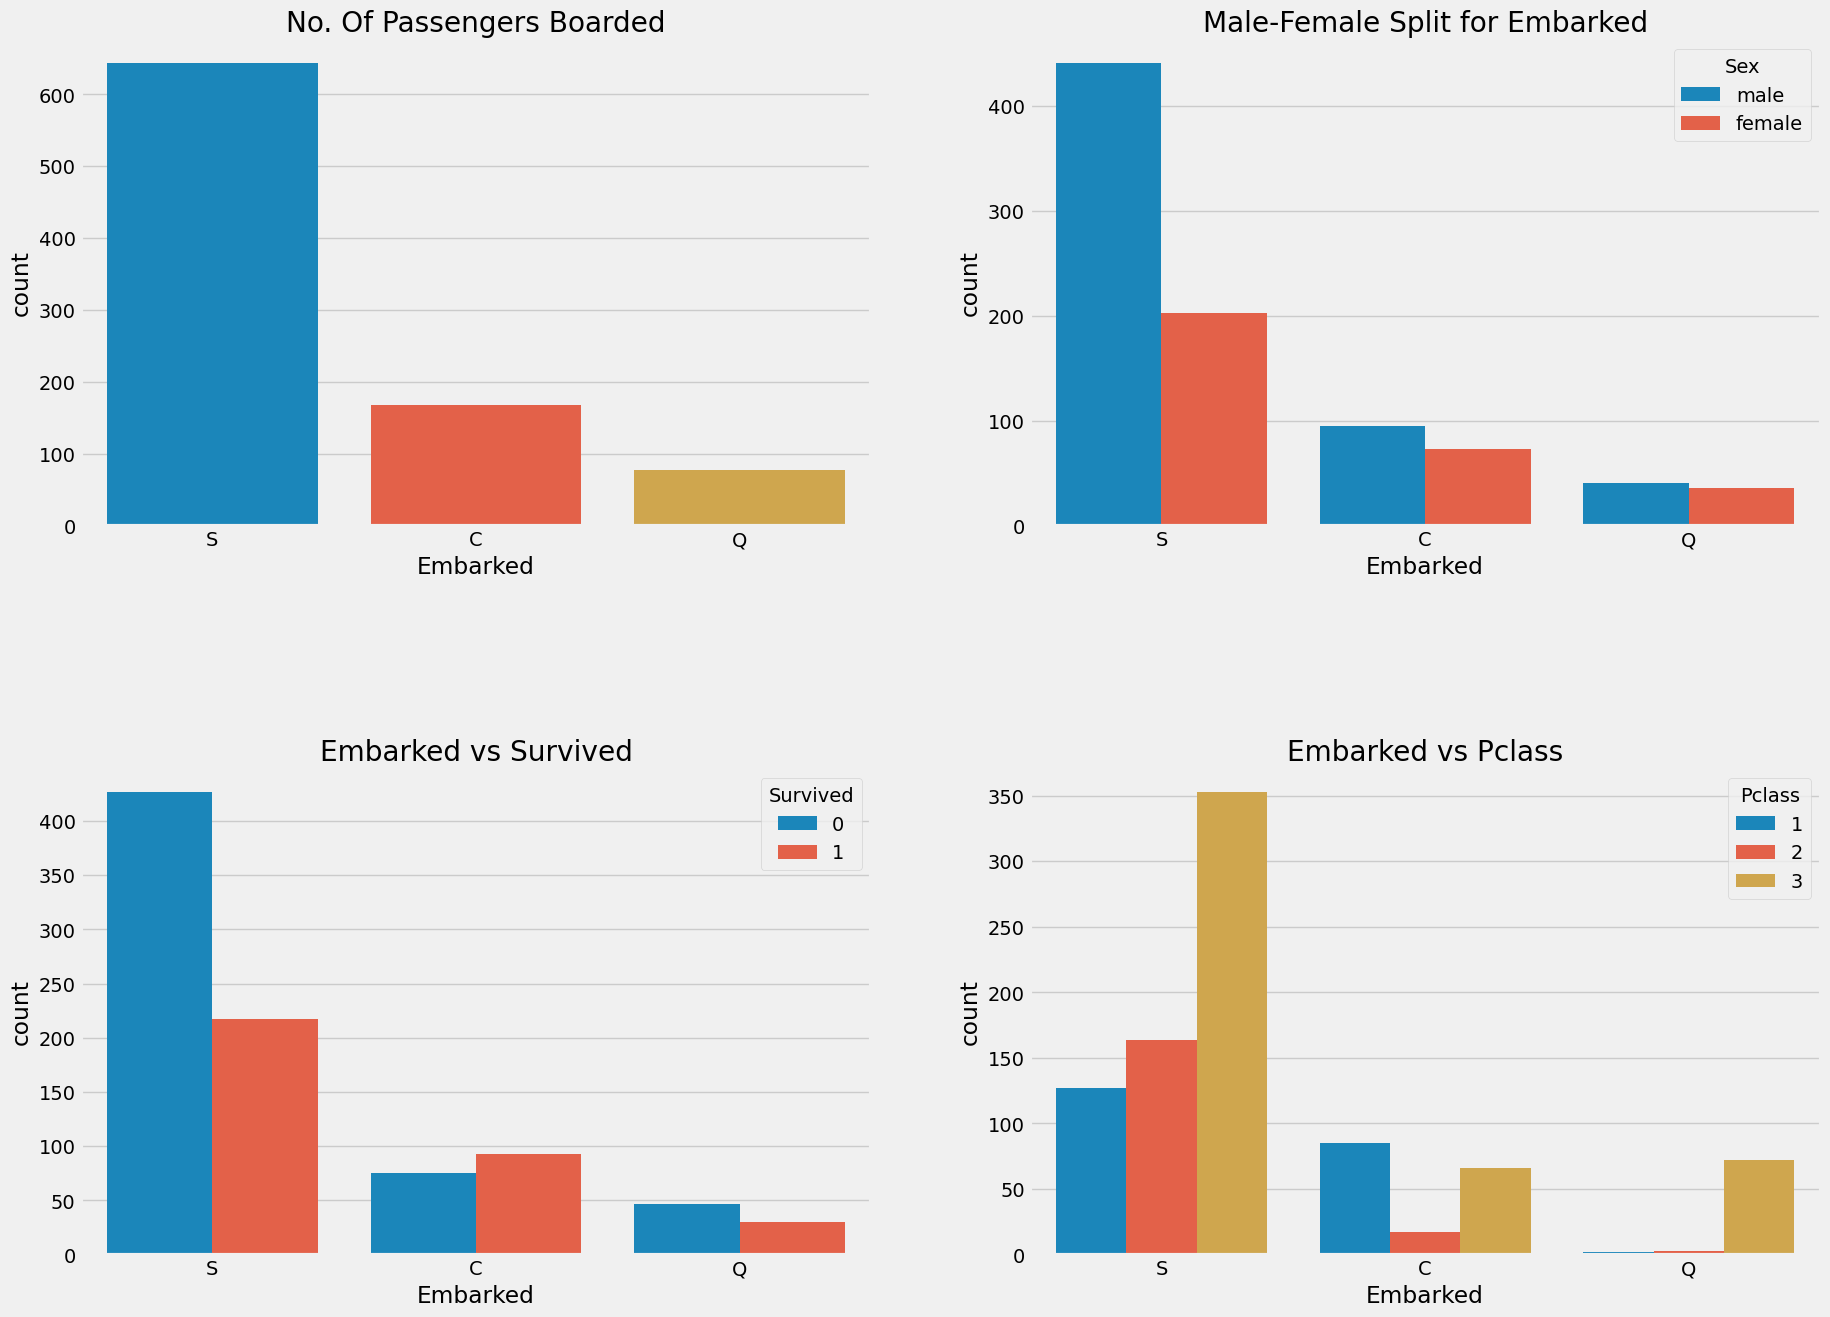

In [24]:
f,ax=plt.subplots(2,2,figsize=(20,15))
sns.countplot(x='Embarked',data=data,ax=ax[0,0])
ax[0,0].set_title('No. Of Passengers Boarded')
sns.countplot(x='Embarked',hue='Sex',data=data,ax=ax[0,1])
ax[0,1].set_title('Male-Female Split for Embarked')
sns.countplot(x='Embarked',hue='Survived',data=data,ax=ax[1,0])
ax[1,0].set_title('Embarked vs Survived')
sns.countplot(x='Embarked',hue='Pclass',data=data,ax=ax[1,1])
ax[1,1].set_title('Embarked vs Pclass')
plt.subplots_adjust(wspace=0.2,hspace=0.5)
plt.show()

Посмотрим на фичу `SibSp`

<Axes: xlabel='SibSp', ylabel='Survived'>

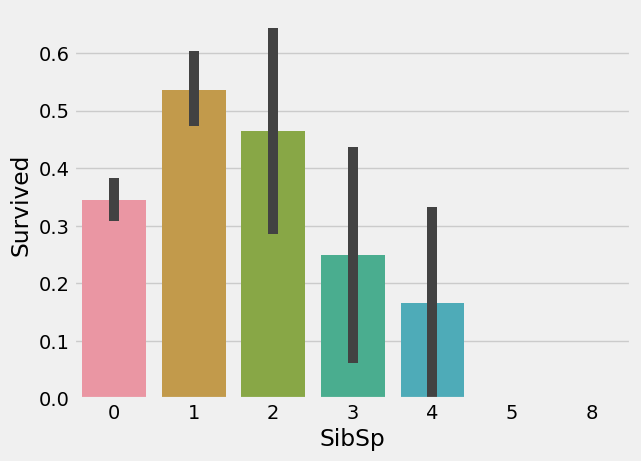

In [28]:
sns.barplot(x='SibSp',y='Survived',data=data)

Посмотрим на фичу `Parch`

<Axes: xlabel='Parch', ylabel='Survived'>

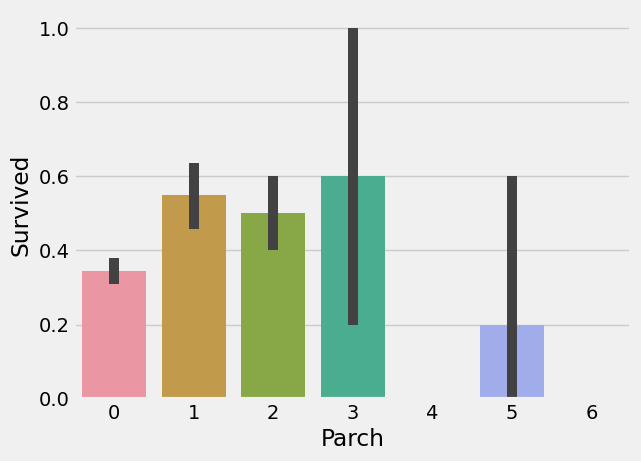

In [31]:
sns.barplot(x='Parch',y='Survived',data=data)

Посмотрим на фичу `Fare`

In [32]:
print('Highest Fare was:',data['Fare'].max())
print('Lowest Fare was:',data['Fare'].min())
print('Average Fare was:',data['Fare'].mean())

Highest Fare was: 512.3292
Lowest Fare was: 0.0
Average Fare was: 32.204207968574636


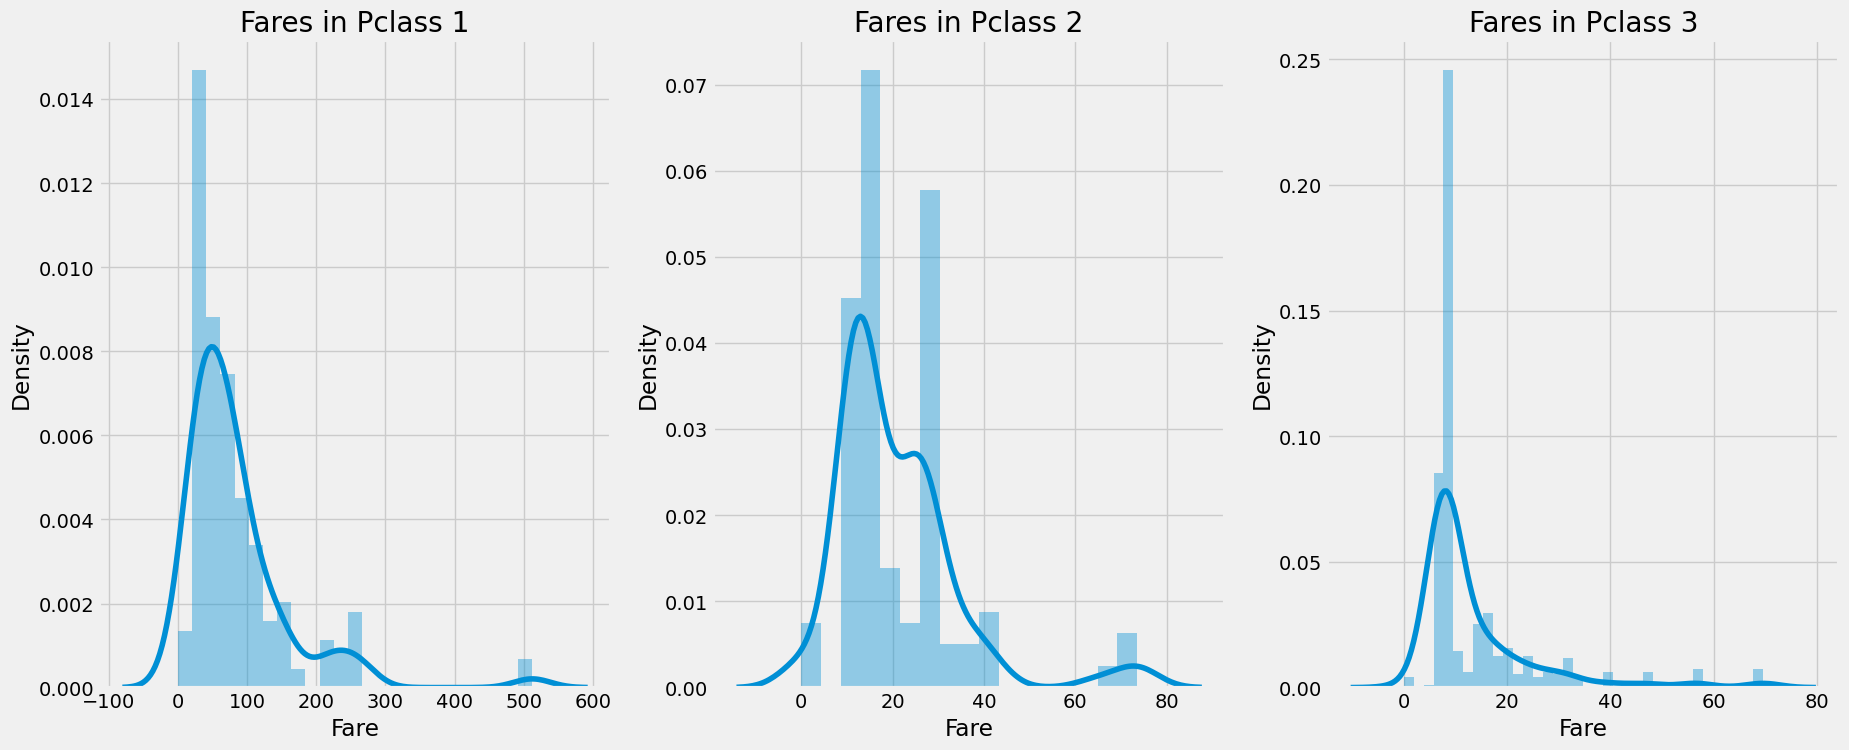

In [33]:
f,ax=plt.subplots(1,3,figsize=(20,8))
sns.distplot(data[data['Pclass']==1].Fare,ax=ax[0])
ax[0].set_title('Fares in Pclass 1')
sns.distplot(data[data['Pclass']==2].Fare,ax=ax[1])
ax[1].set_title('Fares in Pclass 2')
sns.distplot(data[data['Pclass']==3].Fare,ax=ax[2])
ax[2].set_title('Fares in Pclass 3')
plt.show()

**Посмотрим на совместное распределение фичей**

Корреляционная матрица

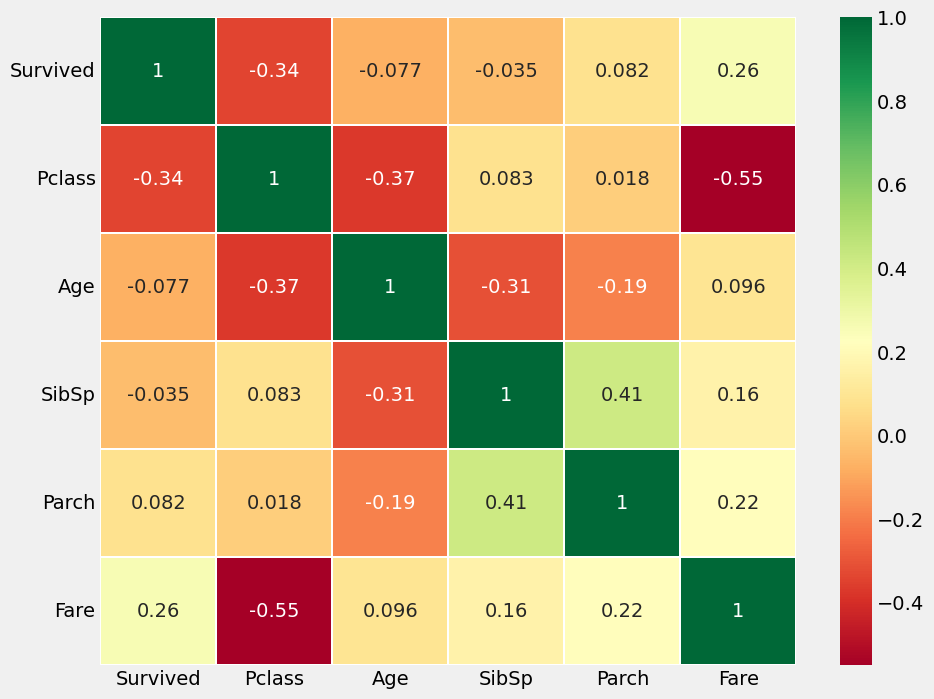

In [34]:
sns.heatmap(data.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

Совместное распределение фичей

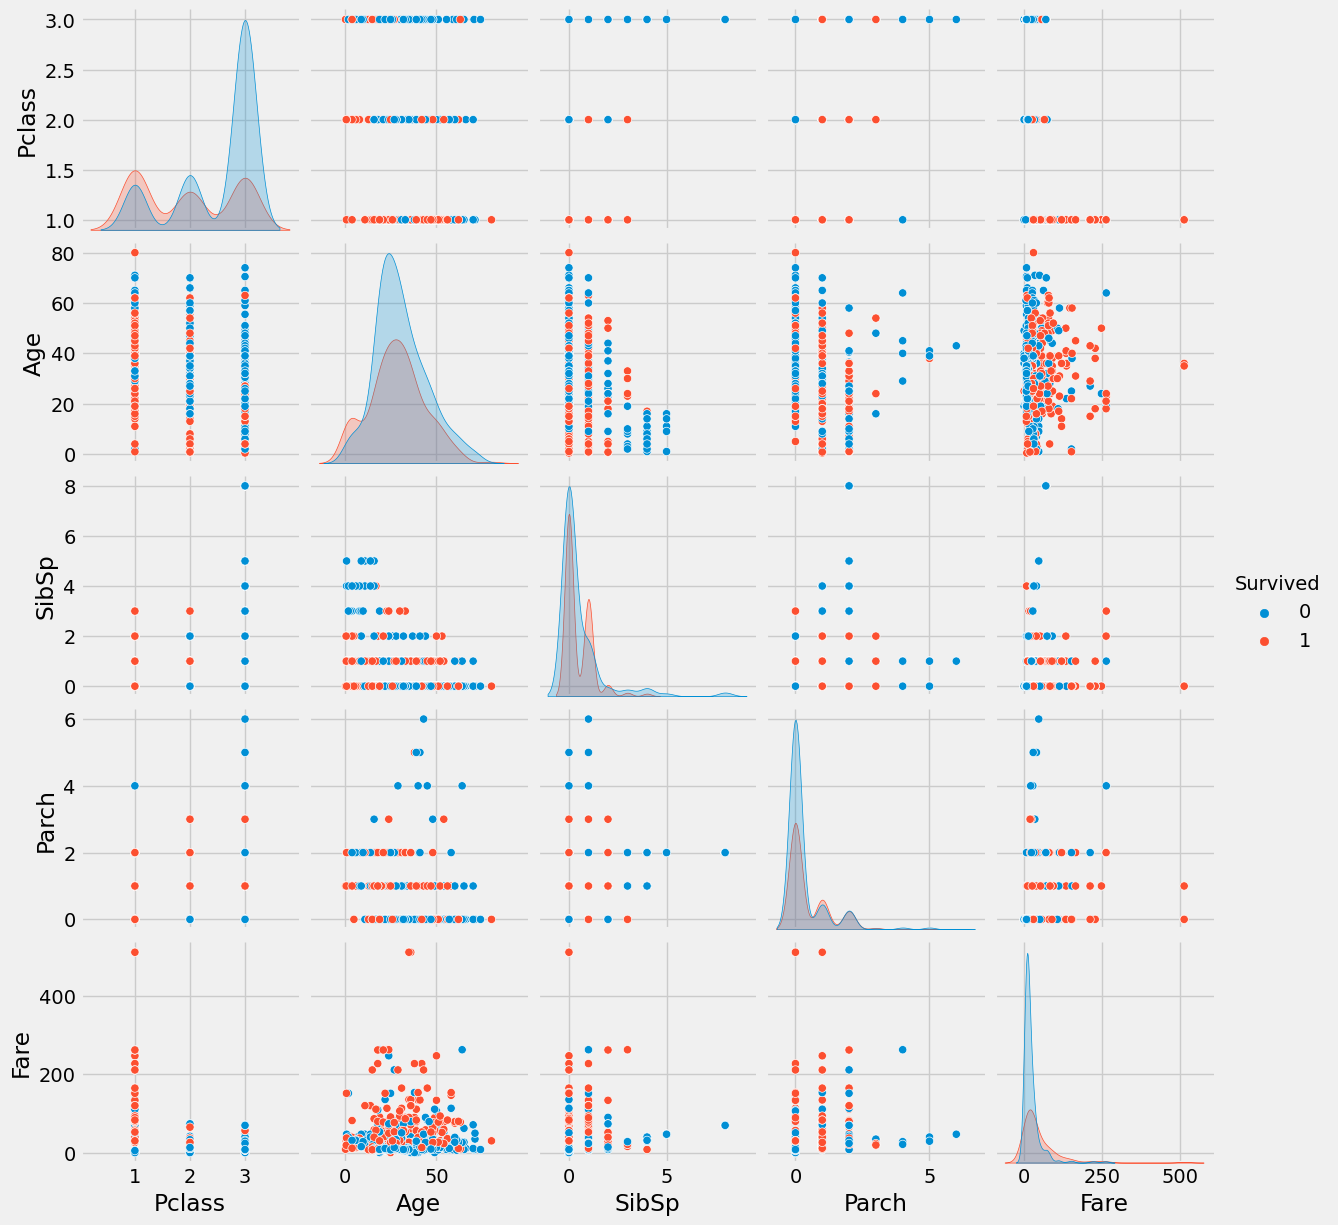

In [35]:
sns.pairplot(data, hue='Survived')

**Выводы по EDA**

- Sex: Шансы на выживание у женщин выше, чем у мужчин.

- Pclass: Существует заметная тенденция: будучи пассажиром 1-го класса, у пассажира больше шансов на выживание. Выживаемость для Pclass3 очень низкая. Для женщин шанс на выживание в группе Pclass1 почти равен 1, а для женщин из Pclass2 она также высока.

- Age: Дети младше 5-10 лет имеют высокие шансы на выживание. Много погибло пассажиров в возрасте от 15 до 35 лет.

- Embarked: Максимальные шансы на выживание в S. Почти все пассажиры из Q были в классе 3.

- Parch+SibSp: наличие 1-2 братьев/сестер, супруга на борту или 1-3 родителей показывает большую вероятность выжить, чем пребывание в одиночестве или большая семья.

## Причешем данные

**Разберемся с пропусками**

In [65]:
data_test = pd.read_csv('./data/raw/test.csv')
data_test.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

In [66]:
def concat_df(train_data, test_data):
    # Returns a concatenated df of training and test set
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

def divide_df(all_data):
    # Returns divided dfs of training and test set
    return all_data.loc[:890], all_data.loc[891:].drop(['Survived'], axis=1)

In [67]:
df_all = concat_df(data, data_test)

In [68]:
df_all.isnull().sum()

Age            263
Embarked         2
Fare             1
Parch            0
PassengerId      0
Pclass           0
Sex              0
SibSp            0
Survived       418
dtype: int64

Заполним пропущенный `Age` по медиане, соответствующей полу и классу билета пассажира

In [69]:
df_all['Age'] = df_all.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

Так же через медиану заполним `Fare` для одного пассажира

In [73]:
df_all[df_all['Fare'].isnull()]

,Age,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived
1043,60.5,S,NaN,0,1044,3,male,0,NaN


In [74]:
med_fare = df_all.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]
df_all['Fare'] = df_all['Fare'].fillna(med_fare)

Заполним `Embarked` самым популярным значением

In [72]:
df_all['Embarked'] = df_all['Embarked'].fillna('S')

In [75]:
df_all.isnull().sum()

Age              0
Embarked         0
Fare             0
Parch            0
PassengerId      0
Pclass           0
Sex              0
SibSp            0
Survived       418
dtype: int64

In [76]:
data, data_test = divide_df(df_all)

## Усредненный портрет пассажира

**По классу билета**

In [89]:
for p_cls in data['Pclass'].unique():
    print(f'Pclass {p_cls}')
    print(f'''Survival rate: {data[data['Pclass'] == p_cls].Survived.mean():.2f}''')
    print(f'''Avg age: {data[data['Pclass'] == p_cls].Age.mean():.2f}''')
    print(f'''Avg Fare: {data[data['Pclass'] == p_cls].Fare.mean():.2f}''')
    sex, sex_counts = np.unique(data[data['Pclass'] == p_cls].Sex, return_counts=True)
    sex_counts = sex_counts / sex_counts.sum()
    print(f'''Sex destribution: {sex[0]} {sex_counts[0]:.2f}, {sex[1]} {sex_counts[1]:.2f}''')
    print(f'''Avg Parch: {data[data['Pclass'] == p_cls].Parch.mean():.2f}''')
    print(f'''Avg SibSp: {data[data['Pclass'] == p_cls].SibSp.mean():.2f}''')
    print('\n')

Pclass 3
Survival rate: 0.24
Avg age: 24.85
Avg Fare: 13.68
Sex destribution: female 0.29, male 0.71
Avg Parch: 0.39
Avg SibSp: 0.62


Pclass 1
Survival rate: 0.63
Avg age: 38.51
Avg Fare: 84.15
Sex destribution: female 0.44, male 0.56
Avg Parch: 0.36
Avg SibSp: 0.42


Pclass 2
Survival rate: 0.47
Avg age: 29.84
Avg Fare: 20.66
Sex destribution: female 0.41, male 0.59
Avg Parch: 0.38
Avg SibSp: 0.40




**По возрасту**

Разделим пассажиров на группы по возрасту

In [91]:
data['Age_band'] = 0
data.loc[data['Age'] < 14,'Age_band'] = 0
data.loc[(data['Age'] >= 14) & (data['Age'] <= 21),'Age_band'] = 1
data.loc[(data['Age'] > 21) & (data['Age'] <= 35),'Age_band'] = 2
data.loc[(data['Age'] > 35) & (data['Age'] <= 55),'Age_band'] = 3
data.loc[data['Age'] > 55,'Age_band'] = 4

In [92]:
data['Age_band'].value_counts().to_frame().style.background_gradient()

,Age_band
2,440
3,207
1,133
0,71
4,40


In [97]:
age_mapping = {
    0:'less than 14',
    1:'14-21',
    2:'21-35',
    3:'35-55',
    4:'55+'}

for p_age in data['Age_band'].unique():
    print(f'Age group {age_mapping[p_age]}')
    print(f'''Survival rate: {data[data['Age_band'] == p_age].Survived.mean():.2f}''')
    print(f'''Avg Fare: {data[data['Age_band'] == p_age].Fare.mean():.2f}''')
    sex, sex_counts = np.unique(data[data['Age_band'] == p_age].Sex, return_counts=True)
    sex_counts = sex_counts / sex_counts.sum()
    print(f'''Sex destribution: {sex[0]} {sex_counts[0]:.2f}, {sex[1]} {sex_counts[1]:.2f}''')
    cls, cls_counts = np.unique(data[data['Age_band'] == p_age].Pclass, return_counts=True)
    cls_counts = cls_counts / cls_counts.sum()
    print(f'''Pclass destribution: {cls[0]} {cls_counts[0]:.2f}, {cls[1]} {cls_counts[1]:.2f}, {cls[2]} {cls_counts[2]:.2f}''')
    print(f'''Avg Parch: {data[data['Age_band'] == p_age].Parch.mean():.2f}''')
    print(f'''Avg SibSp: {data[data['Age_band'] == p_age].SibSp.mean():.2f}''')
    print('\n')

Age group 21-35
Survival rate: 0.36
Avg Fare: 25.52
Sex destribution: female 0.34, male 0.66
Pclass destribution: 1 0.13, 2 0.22, 3 0.65
Avg Parch: 0.22
Avg SibSp: 0.43


Age group 35-55
Survival rate: 0.41
Avg Fare: 46.04
Sex destribution: female 0.35, male 0.65
Pclass destribution: 1 0.52, 2 0.21, 3 0.27
Avg Parch: 0.43
Avg SibSp: 0.36


Age group less than 14
Survival rate: 0.59
Avg Fare: 31.02
Sex destribution: female 0.48, male 0.52
Pclass destribution: 1 0.06, 2 0.25, 3 0.69
Avg Parch: 1.38
Avg SibSp: 1.82


Age group 14-21
Survival rate: 0.34
Avg Fare: 29.37
Sex destribution: female 0.38, male 0.62
Pclass destribution: 1 0.15, 2 0.16, 3 0.69
Avg Parch: 0.32
Avg SibSp: 0.49


Age group 55+
Survival rate: 0.30
Avg Fare: 45.68
Sex destribution: female 0.23, male 0.78
Pclass destribution: 1 0.65, 2 0.17, 3 0.17
Avg Parch: 0.30
Avg SibSp: 0.15




**Преобразуем фичи**

In [105]:
def transform_df(data: pd.DataFrame):
    # Разделим пассажиров на группы по возрасту
    data['Age_band'] = 0
    data.loc[data['Age'] < 14,'Age_band'] = 0
    data.loc[(data['Age'] >= 14) & (data['Age'] <= 21),'Age_band'] = 1
    data.loc[(data['Age'] > 21) & (data['Age'] <= 35),'Age_band'] = 2
    data.loc[(data['Age'] > 35) & (data['Age'] <= 55),'Age_band'] = 3
    data.loc[data['Age'] > 55,'Age_band'] = 4
    # Представим Fare в виде категории
    data['Fare_cat']=0
    data.loc[data['Fare']<=7.91,'Fare_cat']=0
    data.loc[(data['Fare']>7.91) & (data['Fare']<=14.454),'Fare_cat'] = 1
    data.loc[(data['Fare']>14.454) & (data['Fare']<=31),'Fare_cat'] = 2
    data.loc[(data['Fare']>31) & (data['Fare']<=513),'Fare_cat'] = 3
    # Преобразуем строковые данные в числовые
    data['Sex'].replace(['male','female'],[0,1],inplace=True)
    data['Embarked'].replace(['S','C','Q'],[0,1,2],inplace=True)
    data['Pclass'] -= 1
    data.drop(['Age','Fare','PassengerId'],axis=1,inplace=True)

In [110]:
data.head()

,Embarked,Parch,Pclass,Sex,SibSp,Survived,Age_band,Fare_cat
0,0,0,2,0,1,0.0,2,0
1,1,0,0,1,1,1.0,3,3
2,0,0,2,1,0,1.0,2,1
3,0,0,0,1,1,1.0,2,3
4,0,0,2,0,0,0.0,2,1


## Обучим модели предсказания

Подготовим данные

In [121]:
X1 = data[['Embarked','Parch','Sex','SibSp','Age_band', 'Fare_cat']].values
X2 = data[['Embarked','Parch','Pclass','Sex','SibSp','Age_band', 'Fare_cat']].values
y1 = data['Pclass'].values
y2 = data['Survived'].values

In [122]:
ohe1 = OneHotEncoder()
ohe2 = OneHotEncoder()
X1 = ohe1.fit_transform(X1)
X2 = ohe2.fit_transform(X2)

In [124]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.25, random_state=42, stratify=y1)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.25, random_state=42, stratify=y2)

**Предскажем класс билета пассажира**

In [133]:
models = {
    'LogReg': LogisticRegression(), 
    'SVM': SVC(), 
    'DTree': DecisionTreeClassifier()
}

for model_name, model in models.items():
    model.fit(X1_train, y1_train)
    print(f"Model {model_name}, score: {model.score(X1_test, y1_test):.4f}")

Model LogReg, score: 0.7354
Model SVM, score: 0.7399
Model DTree, score: 0.7444


**Предскажем выживание пассажира**

In [134]:
models = {
    'LogReg': LogisticRegression(), 
    'SVM': SVC(), 
    'DTree': DecisionTreeClassifier()
}

for model_name, model in models.items():
    model.fit(X2_train, y2_train)
    print(f"Model {model_name}, score: {model.score(X2_test, y2_test):.4f}")

Model LogReg, score: 0.7803
Model SVM, score: 0.7982
Model DTree, score: 0.7354
